In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Image/ADNI3/* .

In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Split/* .

In [ ]:
# !tar -xzf adni1_brain_resid.tar.gz

In [ ]:
# !tar -xzf adni1_brain_stand.tar.gz

In [ ]:
!cat adni3* | tar xzf -

## Load the images

In [ ]:
import glob

images = sorted(glob.glob('processed/**/*.nii.gz', recursive=True))

In [ ]:
import nibabel as nib

In [ ]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


In [ ]:
# corrupted = check_files(images)

In [ ]:
# corrupted

# CNN - pretrain

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class CNN3D11(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN3D11, self).__init__()

        self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
        self.batch_norm1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
        self.batch_norm_fc = nn.BatchNorm1d(12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return x


In [ ]:
from torchsummary import summary

In [ ]:
model = CNN3D11()
summary(model, (1, 182, 182, 218), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 37, 37, 44]           4,032
       BatchNorm3d-2       [-1, 32, 37, 37, 44]              64
         MaxPool3d-3       [-1, 32, 18, 18, 22]               0
            Conv3d-4       [-1, 16, 18, 18, 22]          13,840
       BatchNorm3d-5       [-1, 16, 18, 18, 22]              32
         MaxPool3d-6         [-1, 16, 9, 9, 11]               0
            Conv3d-7          [-1, 8, 9, 9, 11]           3,464
       BatchNorm3d-8          [-1, 8, 9, 9, 11]              16
         MaxPool3d-9           [-1, 8, 4, 4, 5]               0
          Flatten-10                  [-1, 640]               0
           Linear-11                   [-1, 12]           7,692
      BatchNorm1d-12                   [-1, 12]              24
           Linear-13                    [-1, 3]              39
Total params: 29,203
Trainable params: 

In [ ]:
model = None
del model

## dataset creation

In [ ]:
import pandas as pd

tuning_df = pd.read_csv('ADNI3_tune.csv').drop('Unnamed: 0', axis=1)
testing_df = pd.read_csv('ADNI3_test.csv').drop('Unnamed: 0', axis=1)

In [ ]:
## if two classes:
tuning_df = tuning_df[tuning_df['Group'] != 'MCI']
testing_df = testing_df[testing_df['Group'] != 'MCI']

In [ ]:
from sklearn.model_selection import train_test_split

Subjects, Groups = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).T.to_numpy()
train_subjects, valid_subjects = train_test_split(Subjects, test_size=0.11, random_state=22, stratify=Groups)

train_df = tuning_df[tuning_df['Subject'].isin(train_subjects)][['Image Data ID','Group','Subject']]
train_images, train_labels, train_subjects = train_df.T.to_numpy()

valid_df = tuning_df[tuning_df['Subject'].isin(valid_subjects)][['Image Data ID','Group','Subject']]
valid_images, valid_labels, valid_subjects = valid_df.T.to_numpy()


In [ ]:
import re

def make_id_translator(paths):
  return {re.search('((I|D)\d{3,8})\.', x).group(1): x for x in paths}

id_to_path = make_id_translator(images)

In [ ]:
def image_exists(sample):
  image_id, group = sample
  return image_id in id_to_path

train_set = list(zip(train_images, train_labels))

train_set = list(filter(image_exists, train_set))

train_images, train_labels = zip(*train_set)

In [ ]:
train_image_paths = [id_to_path[k] for k in train_images]

In [ ]:
valid_set = list(zip(valid_images, valid_labels))

valid_set = list(filter(image_exists, valid_set))

valid_images, valid_labels = zip(*valid_set)

In [ ]:
valid_image_paths = [id_to_path[k] for k in valid_images]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import WeightedRandomSampler, RandomSampler


class CNNDatasetShifted(Dataset):

    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.scale = scale

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Min Max Scale normalization
        max_i = img_data.max()
        min_i = img_data.min()
        img_data = (img_data - min_i) / (max_i - min_i)

        # subsample by the factor of 4
        x_shift = random.randint(-1,1)
        y_shift = random.randint(-1,1)
        z_shift = random.randint(-1,1)
        img_data = np.roll(img_data, (x_shift, y_shift, z_shift), (0, 1, 2))

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (42, 42, 50) -> (50, 42, 42)
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)
y_valid_encoded = le.transform(valid_labels)
n_classes = len(le.classes_)

# Compute weights
total = len(y_train_encoded) + len(y_valid_encoded)
weights = [total/(np.count_nonzero(y_train_encoded == i) + np.count_nonzero(y_valid_encoded == i)) for i in range(len(le.classes_))]
scale = 4

# weighted
weight_encoded = [weights[i] for i in y_train_encoded]
sampler = WeightedRandomSampler(weight_encoded, num_samples=scale*len(y_train_encoded), replacement=True)

y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_encoded), num_classes=n_classes).float()
y_valid_one_hot = torch.nn.functional.one_hot(torch.tensor(y_valid_encoded), num_classes=n_classes).float()

# Create custom datasets
train_dataset = CNNDatasetShifted(file_paths=train_image_paths, labels=y_train_one_hot)
valid_dataset = CNNDatasetShifted(file_paths=valid_image_paths, labels=y_valid_one_hot)

batch_size = 32
num_workers = 8
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,  num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



In [ ]:
len(train_loader)

227

In [ ]:
len(valid_loader)

7

## training

In [ ]:
import shutil
import os
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, train_losses, test_losses, scheduler=None, early_stopper=None):

    save_path = '/content/drive/MyDrive/Main_Data/Checkpoints3/part2' # outsource the timepoint

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }

    if scheduler is not None:
        checkpoint['scheduler'] = scheduler.state_dict()

    if early_stopper is not None:
        checkpoint['early_stopper'] = early_stopper.state_dict()

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(filename, model, optimizer, scheduler=None, early_stopper=None):

    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])

    if early_stopper is not None:
        early_stopper.load_state_dict(checkpoint['early_stopper'])

    return epoch, train_losses, test_losses


In [ ]:
from typing import Dict, Any
from typing_extensions import TypeAlias
StateDict: TypeAlias = Dict[str, Any]

class StateDictAttributeError(AttributeError):

  def __init__(self, attribute_name):
    super().__init__(f"your state_dict lacks the parameter \"{attribute_name}\".")


class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def state_dict(self):
      return {"patience": self.patience, "min_delta": self.min_delta, "counter": self.counter, "min_validation_loss": self.min_validation_loss}

    def load_state_dict(self, state_dict: StateDict):

      if "patience" in state_dict:
        self.patience = state_dict["patience"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"patience\".")

      if "min_delta" in state_dict:
        self.min_delta = state_dict["min_delta"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_delta\".")

      if "counter" in state_dict:
        self.counter = state_dict["counter"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"counter\".")

      if "min_validation_loss" in state_dict:
        self.min_validation_loss = state_dict["min_validation_loss"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_validation_loss\".")


In [ ]:
def get_confusion_matrix(y_true, y_pred, classes):
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  return df_cm

In [ ]:
params_filename = '3c_augmented_cnn11_adni3.pth'

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, f1_score

classes = le.classes_
n_classes = len(classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate the model
model = CNN3D11()
model.to(device)

# Number of training epochs
num_epochs = 30

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5) #lr=0.001
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.75, total_iters=num_epochs)
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []

# Load the training data if needed
if os.path.isfile(params_filename):
  s_epoch, train_losses, valid_losses = load_checkpoint(params_filename, model, optimizer, scheduler, early_stopper)

# Training loop
for epoch in range(s_epoch + 1, num_epochs):

    # Training step
    model.train()

    y_true_train = []
    y_pred_train = []
    epoch_train_loss = 0

    print(f'Epoch {epoch}:')
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        y_true_train.extend(torch.argmax(target, dim=1).cpu().numpy())
        y_pred_train.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Training metrics
    epoch_train_loss = epoch_train_loss / len(train_loader)
    print(f'Training Loss: {epoch_train_loss:.4f}')

    train_accuracy = np.sum(np.array(y_true_train) == np.array(y_pred_train)) / len(y_true_train)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    print(f'Training F1-Score: {train_f1 * 100:.2f}%')

    df_cm_train = get_confusion_matrix(y_true_train, y_pred_train, classes)
    print(df_cm_train)


    # Validation step
    model.eval()

    epoch_valid_loss = 0
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_valid_loss += loss.item()
            y_true_valid.extend(torch.argmax(target, dim=1).cpu().numpy())
            y_pred_valid.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Validation metrics
    epoch_valid_loss = epoch_valid_loss / len(valid_loader) # not accurate, needs weighting (in loop multiply by minibatch size, outside divide by length of dataset)
    print(f'Validation Loss: {epoch_valid_loss:.4f}')

    valid_accuracy = np.sum(np.array(y_true_valid) == np.array(y_pred_valid)) / len(y_true_valid)
    print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    valid_f1 = f1_score(y_true_valid, y_pred_valid, average='weighted')
    print(f'Validation F1-Score: {valid_f1 * 100:.2f}%')

    df_cm_valid = get_confusion_matrix(y_true_valid, y_pred_valid, classes)
    print(df_cm_valid)


    # Summing up the epoch
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch, before_lr, after_lr))

    print(f'Epoch {epoch}: saving...')
    save_checkpoint(params_filename, epoch, model, optimizer, train_losses, valid_losses, scheduler=scheduler, early_stopper=early_stopper)

    # Check for early stopping possiblity
    if early_stopper.early_stop(epoch_valid_loss):
      print('Exitting this epoch early...')
      break




Epoch 0:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1335
Training Accuracy: 40.89%
Training F1-Score: 32.55%
           AD        CN       MCI
AD   0.379838  0.608677  0.011484
CN   0.163695  0.824959  0.011345
MCI  0.217320  0.769072  0.013608


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1969
Validation Accuracy: 38.07%
Validation F1-Score: 28.93%
           AD        CN       MCI
AD   0.157895  0.842105  0.000000
CN   0.207921  0.772277  0.019802
MCI  0.163265  0.816327  0.020408
Epoch 0: SGD lr 0.000020 -> 0.000020
Epoch 0: saving...
Epoch 1:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0654
Training Accuracy: 47.05%
Training F1-Score: 39.01%
           AD        CN       MCI
AD   0.542475  0.453213  0.004312
CN   0.164416  0.825258  0.010326
MCI  0.251350  0.718737  0.029913


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1689
Validation Accuracy: 40.83%
Validation F1-Score: 31.02%
           AD        CN       MCI
AD   0.263158  0.684211  0.052632
CN   0.178218  0.811881  0.009901
MCI  0.193878  0.785714  0.020408
Epoch 1: SGD lr 0.000020 -> 0.000020
Epoch 1: saving...
Epoch 2:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0208
Training Accuracy: 51.50%
Training F1-Score: 42.83%
           AD        CN       MCI
AD   0.649873  0.348434  0.001693
CN   0.138400  0.852800  0.008800
MCI  0.269941  0.703191  0.026868


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1805
Validation Accuracy: 41.28%
Validation F1-Score: 30.89%
           AD        CN       MCI
AD   0.368421  0.631579  0.000000
CN   0.178218  0.811881  0.009901
MCI  0.224490  0.765306  0.010204
Epoch 2: SGD lr 0.000020 -> 0.000020
Epoch 2: saving...
Epoch 3:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9844
Training Accuracy: 53.96%
Training F1-Score: 45.64%
           AD        CN       MCI
AD   0.700544  0.298202  0.001255
CN   0.132530  0.857430  0.010040
MCI  0.267033  0.691071  0.041896


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1307
Validation Accuracy: 44.04%
Validation F1-Score: 32.77%
           AD        CN       MCI
AD   0.263158  0.684211  0.052632
CN   0.099010  0.881188  0.019802
MCI  0.183673  0.795918  0.020408
Epoch 3: SGD lr 0.000020 -> 0.000019
Epoch 3: saving...
Epoch 4:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9604
Training Accuracy: 55.70%
Training F1-Score: 47.63%
           AD        CN       MCI
AD   0.741482  0.256388  0.002129
CN   0.122375  0.866721  0.010905
MCI  0.262810  0.676033  0.061157


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1128
Validation Accuracy: 38.99%
Validation F1-Score: 31.98%
           AD        CN       MCI
AD   0.315789  0.631579  0.052632
CN   0.217822  0.732673  0.049505
MCI  0.193878  0.755102  0.051020
Epoch 4: SGD lr 0.000019 -> 0.000019
Epoch 4: saving...
Epoch 5:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9312
Training Accuracy: 58.41%
Training F1-Score: 50.36%
           AD        CN       MCI
AD   0.789362  0.210213  0.000426
CN   0.109394  0.877527  0.013080
MCI  0.253901  0.677773  0.068326


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1164
Validation Accuracy: 47.25%
Validation F1-Score: 39.04%
           AD        CN       MCI
AD   0.368421  0.631579  0.000000
CN   0.108911  0.871287  0.019802
MCI  0.224490  0.693878  0.081633
Epoch 5: SGD lr 0.000019 -> 0.000019
Epoch 5: saving...
Epoch 6:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9131
Training Accuracy: 59.14%
Training F1-Score: 51.83%
           AD        CN       MCI
AD   0.794365  0.200168  0.005467
CN   0.100575  0.887521  0.011905
MCI  0.247737  0.656379  0.095885


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1091
Validation Accuracy: 40.37%
Validation F1-Score: 30.93%
           AD        CN       MCI
AD   0.315789  0.684211  0.000000
CN   0.188119  0.792079  0.019802
MCI  0.214286  0.765306  0.020408
Epoch 6: SGD lr 0.000019 -> 0.000019
Epoch 6: saving...
Epoch 7:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.8848
Training Accuracy: 61.71%
Training F1-Score: 55.12%
           AD        CN       MCI
AD   0.840629  0.155546  0.003825
CN   0.091698  0.893432  0.014870
MCI  0.236842  0.629960  0.133198


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0931
Validation Accuracy: 43.12%
Validation F1-Score: 32.34%
           AD        CN       MCI
AD   0.421053  0.578947  0.000000
CN   0.138614  0.831683  0.029703
MCI  0.153061  0.826531  0.020408
Epoch 7: SGD lr 0.000019 -> 0.000019
Epoch 7: saving...
Epoch 8:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.8699
Training Accuracy: 63.29%
Training F1-Score: 57.08%
           AD        CN       MCI
AD   0.859294  0.136833  0.003873
CN   0.086130  0.897695  0.016175
MCI  0.219861  0.629751  0.150388


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0554
Validation Accuracy: 48.62%
Validation F1-Score: 38.91%
           AD        CN       MCI
AD   0.421053  0.578947  0.000000
CN   0.049505  0.900990  0.049505
MCI  0.153061  0.775510  0.071429
Epoch 8: SGD lr 0.000019 -> 0.000019
Epoch 8: saving...
Epoch 9:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.8407
Training Accuracy: 66.04%
Training F1-Score: 60.68%
           AD        CN       MCI
AD   0.881707  0.116603  0.001690
CN   0.085851  0.895866  0.018283
MCI  0.224481  0.587886  0.187632


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0720
Validation Accuracy: 43.12%
Validation F1-Score: 36.11%
           AD        CN       MCI
AD   0.368421  0.578947  0.052632
CN   0.128713  0.782178  0.089109
MCI  0.173469  0.744898  0.081633
Epoch 9: SGD lr 0.000019 -> 0.000018
Epoch 9: saving...
Epoch 10:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.8312
Training Accuracy: 65.67%
Training F1-Score: 60.40%
           AD        CN       MCI
AD   0.895334  0.101723  0.002942
CN   0.077955  0.898156  0.023889
MCI  0.202098  0.602662  0.195240


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0647
Validation Accuracy: 47.71%
Validation F1-Score: 36.57%
           AD        CN       MCI
AD   0.473684  0.526316  0.000000
CN   0.069307  0.900990  0.029703
MCI  0.153061  0.806122  0.040816
Epoch 10: SGD lr 0.000018 -> 0.000018
Epoch 10: saving...
Epoch 11:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.8045
Training Accuracy: 67.81%
Training F1-Score: 63.40%
           AD        CN       MCI
AD   0.891812  0.105218  0.002970
CN   0.071832  0.905569  0.022599
MCI  0.190120  0.574927  0.234952


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0289
Validation Accuracy: 48.62%
Validation F1-Score: 40.03%
           AD        CN       MCI
AD   0.263158  0.578947  0.157895
CN   0.039604  0.900990  0.059406
MCI  0.112245  0.785714  0.102041
Epoch 11: SGD lr 0.000018 -> 0.000018
Epoch 11: saving...
Epoch 12:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.7888
Training Accuracy: 68.91%
Training F1-Score: 64.87%
           AD        CN       MCI
AD   0.905848  0.090834  0.003318
CN   0.068823  0.903814  0.027363
MCI  0.202809  0.537794  0.259397


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0443
Validation Accuracy: 44.95%
Validation F1-Score: 37.98%
           AD        CN       MCI
AD   0.210526  0.631579  0.157895
CN   0.079208  0.821782  0.099010
MCI  0.102041  0.785714  0.112245
Epoch 12: SGD lr 0.000018 -> 0.000018
Epoch 12: saving...
Epoch 13:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.7689
Training Accuracy: 71.08%
Training F1-Score: 67.72%
           AD        CN       MCI
AD   0.930353  0.066638  0.003009
CN   0.065287  0.896497  0.038217
MCI  0.172070  0.523275  0.304655


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0315
Validation Accuracy: 45.87%
Validation F1-Score: 38.40%
           AD        CN       MCI
AD   0.368421  0.526316  0.105263
CN   0.079208  0.831683  0.089109
MCI  0.173469  0.734694  0.091837
Epoch 13: SGD lr 0.000018 -> 0.000018
Epoch 13: saving...
Epoch 14:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.7541
Training Accuracy: 71.70%
Training F1-Score: 68.59%
           AD        CN       MCI
AD   0.921804  0.076955  0.001241
CN   0.060581  0.904625  0.034793
MCI  0.175755  0.507131  0.317114


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0404
Validation Accuracy: 49.08%
Validation F1-Score: 43.97%
           AD        CN       MCI
AD   0.421053  0.473684  0.105263
CN   0.108911  0.821782  0.069307
MCI  0.163265  0.673469  0.163265
Epoch 14: SGD lr 0.000018 -> 0.000018
Epoch 14: saving...
Epoch 15:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.7389
Training Accuracy: 73.03%
Training F1-Score: 70.34%
           AD        CN       MCI
AD   0.938611  0.059272  0.002117
CN   0.054665  0.906700  0.038635
MCI  0.153532  0.492446  0.354022


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.9965
Validation Accuracy: 50.00%
Validation F1-Score: 48.44%
           AD        CN       MCI
AD   0.421053  0.421053  0.157895
CN   0.118812  0.712871  0.168317
MCI  0.112245  0.591837  0.295918
Epoch 15: SGD lr 0.000018 -> 0.000017
Epoch 15: saving...
Epoch 16:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.7177
Training Accuracy: 74.96%
Training F1-Score: 72.54%
           AD        CN       MCI
AD   0.943801  0.055770  0.000429
CN   0.050801  0.910512  0.038687
MCI  0.163551  0.454121  0.382328


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0125
Validation Accuracy: 50.46%
Validation F1-Score: 46.58%
           AD        CN       MCI
AD   0.368421  0.578947  0.052632
CN   0.079208  0.811881  0.108911
MCI  0.153061  0.632653  0.214286
Epoch 16: SGD lr 0.000017 -> 0.000017
Epoch 16: saving...
Epoch 17:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.7072
Training Accuracy: 75.50%
Training F1-Score: 73.21%
           AD        CN       MCI
AD   0.951777  0.046108  0.002115
CN   0.047040  0.915247  0.037713
MCI  0.161972  0.439519  0.398509


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0434
Validation Accuracy: 50.00%
Validation F1-Score: 45.53%
           AD        CN       MCI
AD   0.684211  0.263158  0.052632
CN   0.108911  0.772277  0.118812
MCI  0.163265  0.653061  0.183673
Epoch 17: SGD lr 0.000017 -> 0.000017
Epoch 17: saving...
Epoch 18:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6849
Training Accuracy: 77.91%
Training F1-Score: 76.12%
           AD        CN       MCI
AD   0.962160  0.036139  0.001701
CN   0.043701  0.916535  0.039764
MCI  0.137330  0.414966  0.447704


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0278
Validation Accuracy: 47.71%
Validation F1-Score: 41.30%
           AD        CN       MCI
AD   0.210526  0.684211  0.105263
CN   0.059406  0.851485  0.089109
MCI  0.132653  0.724490  0.142857
Epoch 18: SGD lr 0.000017 -> 0.000017
Epoch 18: saving...
Epoch 19:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6785
Training Accuracy: 77.40%
Training F1-Score: 75.57%
           AD        CN       MCI
AD   0.968076  0.030680  0.001244
CN   0.036341  0.916458  0.047201
MCI  0.132896  0.424938  0.442166


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.9891
Validation Accuracy: 45.87%
Validation F1-Score: 43.61%
           AD        CN       MCI
AD   0.315789  0.368421  0.315789
CN   0.069307  0.702970  0.227723
MCI  0.163265  0.602041  0.234694
Epoch 19: SGD lr 0.000017 -> 0.000017
Epoch 19: saving...
Epoch 20:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6634
Training Accuracy: 78.66%
Training F1-Score: 77.10%
           AD        CN       MCI
AD   0.970111  0.026900  0.002989
CN   0.042424  0.915960  0.041616
MCI  0.128142  0.394314  0.477544


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0052
Validation Accuracy: 50.00%
Validation F1-Score: 45.95%
           AD        CN       MCI
AD   0.421053  0.368421  0.210526
CN   0.069307  0.792079  0.138614
MCI  0.081633  0.704082  0.214286
Epoch 20: SGD lr 0.000017 -> 0.000017
Epoch 20: saving...
Epoch 21:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6423
Training Accuracy: 80.12%
Training F1-Score: 78.91%
           AD        CN       MCI
AD   0.972696  0.025597  0.001706
CN   0.040205  0.907371  0.052424
MCI  0.110453  0.372408  0.517139


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.9915
Validation Accuracy: 50.46%
Validation F1-Score: 46.52%
           AD        CN       MCI
AD   0.315789  0.526316  0.157895
CN   0.039604  0.801980  0.158416
MCI  0.061224  0.704082  0.234694
Epoch 21: SGD lr 0.000017 -> 0.000016
Epoch 21: saving...
Epoch 22:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6379
Training Accuracy: 80.41%
Training F1-Score: 79.29%
           AD        CN       MCI
AD   0.974060  0.023779  0.002162
CN   0.036401  0.914928  0.048671
MCI  0.117860  0.345133  0.537007


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0610
Validation Accuracy: 44.95%
Validation F1-Score: 40.35%
           AD        CN       MCI
AD   0.315789  0.473684  0.210526
CN   0.059406  0.752475  0.188119
MCI  0.102041  0.734694  0.163265
Epoch 22: SGD lr 0.000016 -> 0.000016
Epoch 22: saving...
Epoch 23:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6158
Training Accuracy: 81.60%
Training F1-Score: 80.60%
           AD        CN       MCI
AD   0.973552  0.025189  0.001259
CN   0.026939  0.922041  0.051020
MCI  0.109867  0.337479  0.552653


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.9504
Validation Accuracy: 48.62%
Validation F1-Score: 47.09%
           AD        CN       MCI
AD   0.263158  0.263158  0.473684
CN   0.039604  0.683168  0.277228
MCI  0.081633  0.591837  0.326531
Epoch 23: SGD lr 0.000016 -> 0.000016
Epoch 23: saving...
Epoch 24:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6042
Training Accuracy: 82.94%
Training F1-Score: 82.20%
           AD        CN       MCI
AD   0.978715  0.019616  0.001669
CN   0.030328  0.912705  0.056967
MCI  0.091777  0.311877  0.596346


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0049
Validation Accuracy: 46.33%
Validation F1-Score: 43.60%
           AD        CN       MCI
AD   0.421053  0.263158  0.315789
CN   0.069307  0.702970  0.227723
MCI  0.122449  0.653061  0.224490
Epoch 24: SGD lr 0.000016 -> 0.000016
Epoch 24: saving...
Epoch 25:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5921
Training Accuracy: 83.27%
Training F1-Score: 82.55%
           AD        CN       MCI
AD   0.979747  0.018987  0.001266
CN   0.033075  0.913434  0.053491
MCI  0.101031  0.291546  0.607423


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.9942
Validation Accuracy: 49.08%
Validation F1-Score: 45.66%
           AD        CN       MCI
AD   0.368421  0.368421  0.263158
CN   0.059406  0.762376  0.178218
MCI  0.061224  0.704082  0.234694
Epoch 25: SGD lr 0.000016 -> 0.000016
Epoch 25: saving...
Epoch 26:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5756
Training Accuracy: 84.37%
Training F1-Score: 83.77%
           AD        CN       MCI
AD   0.982590  0.015711  0.001699
CN   0.023625  0.924644  0.051731
MCI  0.078472  0.293755  0.627773


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0139
Validation Accuracy: 49.08%
Validation F1-Score: 46.07%
           AD        CN       MCI
AD   0.421053  0.368421  0.210526
CN   0.049505  0.742574  0.207921
MCI  0.081633  0.673469  0.244898
Epoch 26: SGD lr 0.000016 -> 0.000016
Epoch 26: saving...
Epoch 27:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5569
Training Accuracy: 85.51%
Training F1-Score: 84.99%
           AD        CN       MCI
AD   0.986187  0.012976  0.000837
CN   0.029508  0.927459  0.043033
MCI  0.077847  0.269979  0.652174


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.9944
Validation Accuracy: 47.71%
Validation F1-Score: 43.25%
           AD        CN       MCI
AD   0.210526  0.473684  0.315789
CN   0.019802  0.792079  0.188119
MCI  0.091837  0.704082  0.204082
Epoch 27: SGD lr 0.000016 -> 0.000015
Epoch 27: saving...
Epoch 28:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5561
Training Accuracy: 85.28%
Training F1-Score: 84.82%
           AD        CN       MCI
AD   0.984791  0.011829  0.003380
CN   0.027038  0.914725  0.058236
MCI  0.079256  0.254347  0.666397


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0216
Validation Accuracy: 46.79%
Validation F1-Score: 42.78%
           AD        CN       MCI
AD   0.263158  0.421053  0.315789
CN   0.039604  0.762376  0.198020
MCI  0.081633  0.714286  0.204082
Epoch 28: SGD lr 0.000015 -> 0.000015
Epoch 28: saving...
Exitting this epoch early...


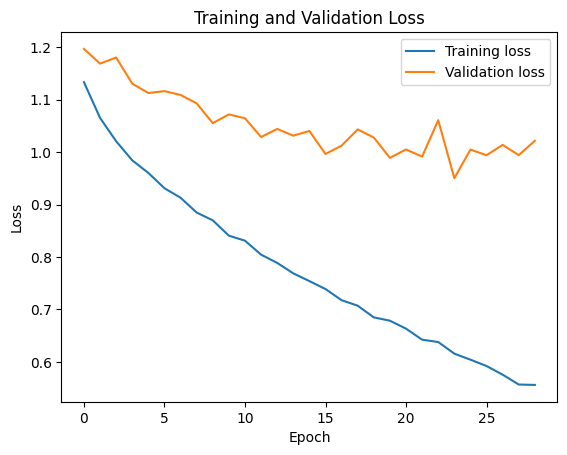

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()